In [1]:
import pystan
import lenskit

In [2]:
uniform_model_code = """
data {
    int<lower=1> U; // number of users
    int<lower=1> I; // number of items
    int<lower=1> L; // length of the recommendation list
    int<lower=0,upper=1> X[U*I];
    int<lower=0> REC_LIST[U, L];
}
parameters {
    real<lower=0> alpha;
    real<lower=0> b;
    real<lower=0, upper=1> pi[U*I];
}
model {
    alpha ~ exponential(0.001);
    b ~ exponential(0.001);
    pi ~ beta(alpha, b);            
    X ~ bernoulli(pi);
}
generated quantities {
    real recall[U];

    for (u in 1:U) {
        real pi_u[I];
        real pi_l[L];
        real n_pi;
        real k_pi;
        int start = (u - 1) * I;
        
        for (i in 1:I) {
            pi_u[i] = pi[start + i];
        }    
        n_pi = sum(round(pi_u));
        
        for (i in 1:L) {
            int item_id = REC_LIST[u,i] + start + 1;
            pi_l[i] = pi[item_id];
        }
        k_pi = sum(round(pi_l));
        
        recall[u] = n_pi / k_pi;
    }          
}
"""

In [3]:
import pandas as pd

In [4]:
ratings = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=['user', 'item', 'rating', 'timestamp']).drop('timestamp', axis=1)

In [5]:
ratings['rel'] = 1

In [6]:
train = pd.read_csv('./build/train.csv')
test = pd.read_csv('./build/test.csv')
recommendations = pd.read_csv('./build/recommendations_item-item.csv')

Index all the items and the sample users in the recommendation lists.

In [7]:
item_index = pd.Index(ratings.item.unique())
user_index = pd.Index(recommendations.user.unique())

In [8]:
from scipy.sparse import csr_matrix

In [9]:
sample_ratings = ratings[ratings['user'].isin(recommendations['user'].unique())]

In [10]:
rows = user_index.get_indexer(sample_ratings['user'])
cols = item_index.get_indexer(sample_ratings['item'])
data = sample_ratings['rel'].values

In [11]:
nusers = len(user_index)
nitems = len(item_index)
print(nusers, nitems)

20 1682


In [12]:
csr_ratings = csr_matrix((data, (rows, cols)), shape=(nusers, nitems))

Convert sparse user-item pair to dense matrix in order to sample

In [13]:
dense_ratings = csr_ratings.toarray()

In [14]:
print(dense_ratings.shape)

(20, 1682)


In [15]:
X = dense_ratings.ravel()

In [16]:
print(len(X), nusers * nitems)

33640 33640


In [17]:
recommendations['item_ind'] = item_index.get_indexer(recommendations['item'])

In [18]:
recommendations['user_ind'] = user_index.get_indexer(recommendations['user'])

In [19]:
REC_LIST = recommendations[['user_ind', 'item_ind', 'rank']].pivot_table(index='user_ind', columns='rank', values='item_ind').values
L = REC_LIST.shape[1]

In [20]:
model_data = {'U': nusers,
              'I': nitems,
              'L': L,
              'REC_LIST':REC_LIST,
              'X': X}

sm = pystan.StanModel(model_code=uniform_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a5f2e19446ee01e66e476753d50abf83 NOW.
/home/MucunTian/anaconda3/envs/eval-error/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp35bp4ka6/stanfit4anon_model_a5f2e19446ee01e66e476753d50abf83_2647608838872665062.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [21]:
import pickle as pkl

In [22]:
with open('build/uniform_model.pkl', 'wb') as f:
    pkl.dump(sm, f)

In [48]:
sm = None
with open('build/uniform_model.pkl', 'rb') as f:
    sm = pkl.load(f)

In [23]:
fit = sm.sampling(data=model_data, iter=1000, chains=4, n_jobs=14)
# fit = sm.sampling(data=model_data, iter=2000, chains=4, n_jobs=14, control={'max_treedepth': 15})

In [24]:
la = fit.extract(permuted=True)

In [30]:
with open('build/uniform_model_sampling.pkl', 'wb') as f:
    pkl.dump(la, f)

In [31]:
la_loaded = None
with open('build/uniform_model_sampling.pkl', 'rb') as f:
    la_loaded = pkl.load(f)

In [36]:
import numpy as np

In [41]:
la_loaded['pi'].shape

(2000, 33640)

In [42]:
np.argwhere(la_loaded['pi'] > 0.5)

array([], shape=(0, 2), dtype=int64)

In [39]:
np.argwhere(np.isnan(la_loaded['recall']))

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [1999,   17],
       [1999,   18],
       [1999,   19]])

Metric on Observations

In [113]:
rec_rel = recommendations.merge(test, how='left', on=['user', 'item'])[['user','item','rating']]
rec_rel['relevant'] = rec_rel['rating'] > 0
rec_tp = rec_rel.groupby('user').sum()['relevant'].reset_index()
total_pos = ratings[['user','item']].groupby('user',as_index=False).count()
obs_recall = rec_tp.merge(total_pos)
obs_recall['recall'] = obs_recall.relevant / obs_recall.item

In [116]:
obs_recall.head()

,user,relevant,item,recall
0,1,5.0,272,0.018382
1,2,2.0,62,0.032258
2,3,0.0,54,0.000000
3,4,0.0,24,0.000000
4,5,0.0,175,0.000000


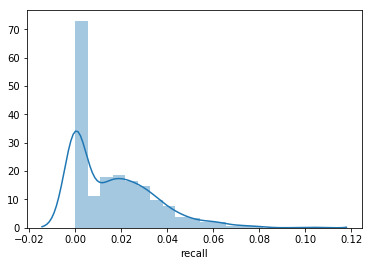

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(obs_recall.recall)
plt.show()

Metric on Inferences

In [25]:
la = fit.extract(permuted=True)

In [123]:
true_pref = pd.DataFrame.from_records(la['pi'][5000])

In [156]:
true_pref_tall = true_pref.stack().reset_index().rename(columns={'level_0':'user',
                                                'level_1':'item',
                                                0:'pref'})
true_pref_tall['rel'] = true_pref_tall['pref'] > 0.5
true_pref_tall.loc[:, 'user'] = true_pref_tall['user'] + 1
true_pref_tall.loc[:, 'item'] = true_pref_tall['item'] + 1

In [158]:
true_rec_rel = recommendations.merge(true_pref_tall, how='left', on=['user', 'item'])[['user','item','rel']]

true_rec_tp = true_rec_rel[['user', 'rel']].groupby('user').sum()['rel'].reset_index()
true_total_pos = true_pref_tall[['user','item']].groupby('user',as_index=False).count()
true_recall = true_rec_tp.merge(true_total_pos)
true_recall['recall'] = true_recall.rel / true_recall.item

In [159]:
true_recall

,user,rel,item,recall
0,1,0,10,0.0
1,2,0,10,0.0
2,3,0,10,0.0
3,4,0,10,0.0
4,5,0,10,0.0
5,6,0,10,0.0
6,7,0,10,0.0
7,8,0,10,0.0
8,9,0,10,0.0
9,10,0,10,0.0


In [ ]:
"""
transformed parameters {
    matrix<lower=0, upper=1>[U, I] psi_transformed;
    psi_transformed = 1 - pi + psi
}
generated quantities {

}
"""